# Revenue Forecasting

### Company Background

Inn the Neighborhood is an online platform that allows people to rent out their properties for short stays. At the moment, only 2% of people who come to the site interested in renting out their homes start to use it.

The product manager would like to increase this. They want to develop an application to help people estimate how much they could earn renting out their living space. They hope that this would make people more likely to sign up.

### Success Criteria

They want to avoid estimating prices that are more than 25 dollars off of the actual price, as this may discourage people. Develop a way to predict how much someone could earn from renting their property.


### Summary
Listing price was most strongly predicted by the number of bedrooms and the location, followed by the minimum nights of the stay and whether the room was shared or private. 

Using this algorithm, the median difference between estimated and actual listing price was $25

With this information, we can provide customers with confidence about what they can earn by listing their property with us, increasing customer conversion and retention

# Import Packages and Data

The imported data contains information from 8,111 potential rental properties and there are 9 columns of data. 

In [282]:
# Import packages for analysis and visualization
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patheffects as path_effects
import seaborn as sns
import numpy as np
pd.set_option('display.float_format', lambda x: '%.2f' % x)
transform_in_model = True


In [283]:
df_raw = pd.read_csv("data/rentals.csv")

# First clean up the price variable to be a clean float
df_raw['price'] = df_raw['price'].str.replace('$','').str.replace(',','').astype(float)

print("The size of the data is: {}".format(df_raw.shape))
df_raw.head(20)

The size of the data is: (8111, 9)


,id,latitude,longitude,property_type,room_type,bathrooms,bedrooms,minimum_nights,price
0,958,37.77,-122.43,Apartment,Entire home/apt,1.00,1.00,1,170.00
1,3850,37.75,-122.46,House,Private room,1.00,1.00,1,99.00
2,5858,37.75,-122.42,Apartment,Entire home/apt,1.00,2.00,30,235.00
3,7918,37.77,-122.45,Apartment,Private room,4.00,1.00,32,65.00
4,8142,37.76,-122.45,Apartment,Private room,4.00,1.00,32,65.00
5,8339,37.78,-122.44,House,Entire home/apt,1.50,2.00,6,875.00
6,8739,37.76,-122.42,Condominium,Private room,1.00,1.00,1,139.00
7,9225,37.76,-122.41,House,Private room,1.00,1.00,1,135.00
8,10251,37.76,-122.41,House,Entire home/apt,1.00,2.00,30,225.00
9,10578,37.79,-122.42,Apartment,Entire home/apt,1.00,0.00,30,120.00


# Data Exploration

### Summary of data changes
- **Price:** Converted to float and transformed to decrease skewness
- **Geolocation (latitude and longitude):** No changes needed
- **Property Type:** Condensed into 5 most common categories, plus an other
- **Room Type:** No changes needed
- **Bathrooms:** Skewness detected
- **Bedrooms:** Skewness detected
- **Minimum Nights:** Skewness detected

**Note:** Outliers/extreme values were detected on price, bedrooms, bathrooms, and minimum nights of the stay. The outliers will be handled in a later section. 


See below for changes in the code

## Price (in $ per night charged)

Price is the main dependent variable for this project. First, I need to convert it from a character into a float value (done above when importing the data, but worth mentioning here) and then check the distribution. When looking at the distribution, there is a very strong right skew so I decided to perform a transformation which decreased the skewness coefficient from 16 down to near zero.  

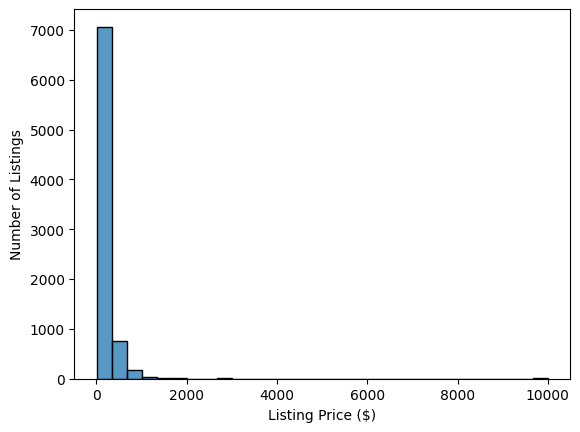

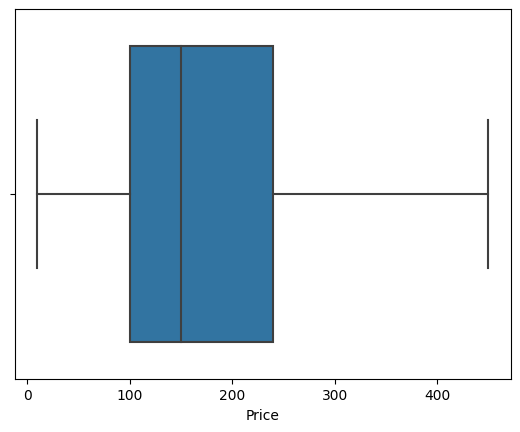

Skew values before and after transformation:
price       16.16
log_price   -0.04
dtype: float64


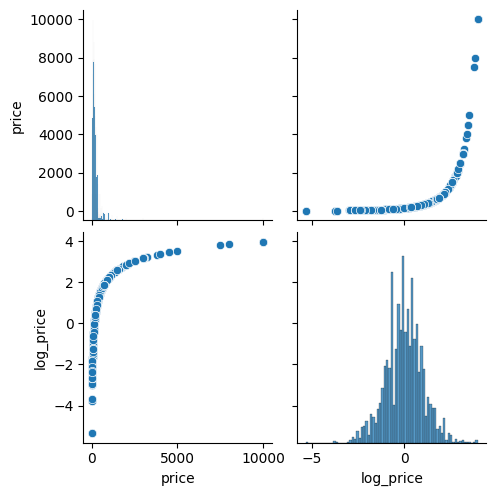

In [284]:
from sklearn.preprocessing import PowerTransformer

df_raw = df_raw[df_raw['price'] > 0]
log_price = PowerTransformer(method = 'box-cox')
# log_price = PowerTransformer()
log_price.fit(df_raw[['price']])
df_raw['log_price'] = log_price.transform(df_raw[['price']])

sns.histplot(x = 'price', data = df_raw, bins = 30)
plt.ylabel('Number of Listings')
plt.xlabel('Listing Price ($)')
plt.show()

sns.boxplot(x= 'price', data= df_raw, showfliers = False)
plt.xlabel('Price')
plt.show()

print('Skew values before and after transformation:')
print(df_raw[['price','log_price']].skew(axis = 0, skipna = True))
sns.pairplot(df_raw[['price','log_price']])
# plt.ylabel('Number of Listings')
# plt.xlabel('Listing Price')
plt.show()

## Geo-Location

Through both the use of a scatterplot and a basic map of California, it seems that all of these listing are for the San Francisco metropolitan area. No further change is needed for these features. I will leave the latitude and longitude as is in the dataset 

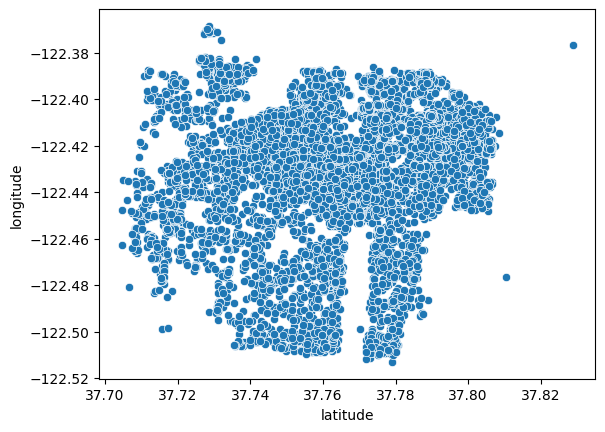

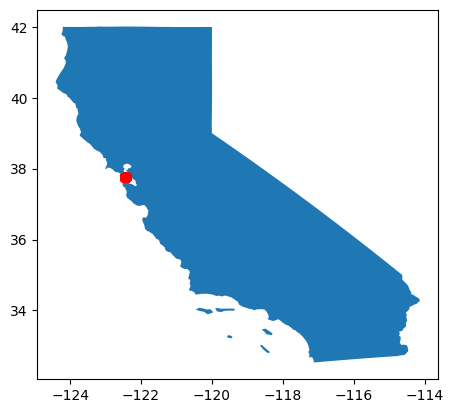

In [285]:
# Basic Latitude and Longitude scatterplot
sns.scatterplot('latitude','longitude', data = df_raw)
plt.show()

from shapely.geometry import Point
import geopandas as gpd
from geopandas import GeoDataFrame
import matplotlib.pyplot as plt

geometry = [Point(xy) for xy in zip(df_raw['longitude'],df_raw['latitude'])]
gdf = GeoDataFrame(df_raw, geometry=geometry)

states = gpd.read_file('data/usa-states-census-2014.shp')
california = states[states['NAME'] == 'California']

world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
gdf.plot(ax=california.plot(), marker = 'o', color = 'red', markersize = 15)
plt.show()

## Property Type

Upon review of the property type, it appears that over 95% of the listings fit into just 5 categories. While I could probably leave the property type as is, I like to condense categorical variables into fewer categories to reduce the risk that any one feature will skew the model because of unnecessary variability. I will include an other to account for the remaining property types. 

In [286]:
# Preliminary Counts
property_counts = df_raw.groupby(['property_type']).size().reset_index(name = 'counts').sort_values(['counts'],ascending = False)
property_counts['Cumulative'] = property_counts['counts'].cumsum() / df_raw.shape[0]
property_counts

,property_type,counts,Cumulative
1,Apartment,3243,0.40
16,House,2314,0.69
8,Condominium,891,0.80
12,Guest suite,577,0.87
3,Boutique hotel,267,0.90
15,Hotel,157,0.92
24,Townhouse,142,0.94
22,Serviced apartment,121,0.95
14,Hostel,92,0.96
19,Loft,88,0.97


In [287]:
df_raw['property_type'] = np.where(df_raw['property_type'].str.contains('apartment',case = False),'Apartment',
                          np.where(df_raw['property_type'].str.contains('house',case = False),'House',
                          np.where(df_raw['property_type'].str.contains('condo',case = False),'Condominium',
                          np.where(df_raw['property_type'].str.contains('guest suite',case = False),'Guest Suite',
						  np.where(df_raw['property_type'].str.contains('hotel',case = False),'Hotel','Other')))))

# Preliminary Counts
property_counts = df_raw.groupby(['property_type']).size().reset_index(name = 'counts').sort_values(['counts'],ascending = False)
property_counts['Cumulative'] = property_counts['counts'].cumsum() / df_raw.shape[0]
property_counts

,property_type,counts,Cumulative
0,Apartment,3364,0.41
4,House,2503,0.72
1,Condominium,891,0.83
2,Guest Suite,577,0.90
3,Hotel,465,0.96
5,Other,310,1.00


## Room Type

Room type already comes in a clean format with only 4 categories, so no further cleaning is required.

As a further data validation step, I was curious about the consistency between room type and property type. I wanted to ensure that there was consistency but that the information within each column was unique. I did find a fair degree of agreement between the two columns but I also found that there was enough variation in the pattern that the model would benefit from training on both columns. 

In [288]:
# Preliminary Counts
room_counts = df_raw.groupby(['room_type']).size().reset_index(name = 'counts').sort_values(['counts'],ascending = False)
room_counts['Cumulative'] = room_counts['counts'].cumsum() / df_raw.shape[0]
room_counts

,room_type,counts,Cumulative
0,Entire home/apt,4772,0.59
2,Private room,2890,0.94
3,Shared room,241,0.97
1,Hotel room,207,1.00


In [289]:
pd.crosstab(df_raw['property_type'],df_raw['room_type'], margins = True)

room_type,Entire home/apt,Hotel room,Private room,Shared room,All
property_type,,,,,
Apartment,2461,38,785,80,3364
Condominium,633,0,256,2,891
Guest Suite,495,0,82,0,577
Hotel,20,108,334,3,465
House,1066,0,1335,102,2503
Other,97,61,98,54,310
All,4772,207,2890,241,8110


## Bathrooms and Bedrooms

Upon review of the bedrooms and bathrooms, I detected both outliers and mising values. Both of these will be cleaned up in the data preprocessing section. I also wanted to check that the correlation between these two features was not too high and indeed, I found that the correlation was ~.33, which does not suggest collinearity. 

Listing Size Distribution:
       bedrooms  bathrooms
count   8106.00    8098.00
mean       1.35       1.40
std        0.93       0.92
min        0.00       0.00
25%        1.00       1.00
50%        1.00       1.00
75%        2.00       1.50
max       14.00      14.00

Summary of Missing Values:
bedrooms      4
bathrooms    12
dtype: int64

Correlation Coefficient for bedrooms and bathrooms is 0.33


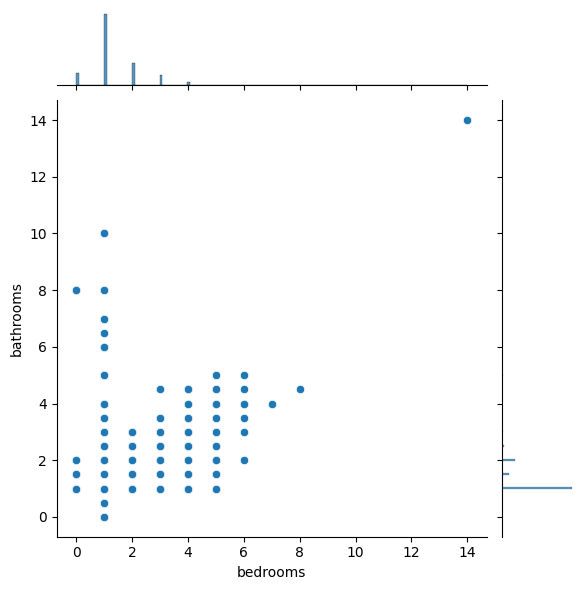

In [290]:
print("Listing Size Distribution:")
print(df_raw[['bedrooms','bathrooms']].describe())
print("\nSummary of Missing Values:")
print(df_raw[['bedrooms','bathrooms']].isna().sum().sort_values())
print("\nCorrelation Coefficient for bedrooms and bathrooms is {:.2f}".format(df_raw['bedrooms'].corr(df_raw['bathrooms'])))
sns.jointplot('bedrooms','bathrooms',data = df_raw)
plt.show()

In [291]:
# log_bed = PowerTransformer()
# log_bed.fit(df_raw[['bedrooms']])
# df_raw['bedrooms'] = 

# # log_price = PowerTransformer()
# log_price.fit(df_raw[['price']])
# df_raw['log_price'] = log_price.transform(df_raw[['price']])


print('Skew values before:')
print(df_raw[['bedrooms','bathrooms','minimum_nights']].skew(axis = 0, skipna = True))

Skew values before:
bedrooms          1.57
bathrooms         4.41
minimum_nights   90.06
dtype: float64


## Minimum Nights

There are also outliers within the minimum nights required, and these were removed above. It appears that the distribution is still right-skewed but I will keep the rest of the data as is. 

count        8110.00
mean        12346.78
std       1110425.69
min             1.00
25%             2.00
50%             4.00
75%            30.00
max     100000000.00
Name: minimum_nights, dtype: float64


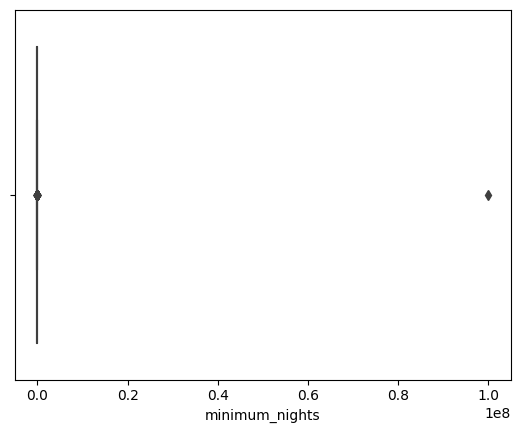

In [292]:
print(df_raw['minimum_nights'].describe())
sns.boxplot(df_raw['minimum_nights'])
plt.show()

# Data preprocessing

Because this is a prediction problem using a continuous numeric variable, I am going to look at a few algorithms for continuous predictions. However, before I train the model, I need to perform some preprocessing steps

**Summary:**
- **Outliers:** Outliers were detected for approximately 10% of the sample across 4 columns and I chose to clean up these columns in a few ways:
	1. **Price** was cleaned through logarithmic transformation, then the top 5% of values were also removed because they were very extreme and I wanted the model to focus efforts on the most common listings. Additionally, price was required to be positive.
    2. **Other Columns**- An additional 5 percent of the sample were classified as outliers using the interquartile range method. 
- **Missing Data:** There were a few listings that were missing values for bedrooms and bathrooms. Since these values were so minimal, I decided to fill those missing values with the mean. 
- **One-hot dummy encoding:** Because the numerical algorithm does not know how to handle categorial data, I used one-hot dummy encoding to take advantage of the categorical information. 

In [293]:
df_raw.head()

,id,latitude,longitude,property_type,room_type,bathrooms,bedrooms,minimum_nights,price,log_price,geometry
0,958,37.77,-122.43,Apartment,Entire home/apt,1.00,1.00,1,170.00,0.16,POINT (-122.43386 37.76931)
1,3850,37.75,-122.46,House,Private room,1.00,1.00,1,99.00,-0.65,POINT (-122.45805 37.75402)
2,5858,37.75,-122.42,Apartment,Entire home/apt,1.00,2.00,30,235.00,0.60,POINT (-122.42102 37.74511)
3,7918,37.77,-122.45,Apartment,Private room,4.00,1.00,32,65.00,-1.34,POINT (-122.45250 37.76669)
4,8142,37.76,-122.45,Apartment,Private room,4.00,1.00,32,65.00,-1.34,POINT (-122.45183 37.76487)


## Outliers

In [294]:
print(df_raw[['price','log_price','bedrooms','bathrooms','minimum_nights']].skew(axis = 0, skipna = True))
print(df_raw[['price','log_price','bedrooms','bathrooms','minimum_nights']].describe())


price            16.16
log_price        -0.04
bedrooms          1.57
bathrooms         4.41
minimum_nights   90.06
dtype: float64
         price  log_price  bedrooms  bathrooms  minimum_nights
count  8110.00    8110.00   8106.00    8098.00         8110.00
mean    225.43       0.00      1.35       1.40        12346.78
std     412.27       1.00      0.93       0.92      1110425.69
min      10.00      -5.33      0.00       0.00            1.00
25%     100.00      -0.63      1.00       1.00            2.00
50%     150.00      -0.02      1.00       1.00            4.00
75%     240.00       0.63      2.00       1.50           30.00
max   10000.00       3.97     14.00      14.00    100000000.00


In [295]:
price_q1 = df_raw['price'].quantile(0.25)
price_q3 = df_raw['price'].quantile(0.75)
price_IQR = price_q3 - price_q1
# price_outlier_high = df_raw['price'] > (price_q3 + 1.5*price_IQR)
price_outlier_high = df_raw['price'] >= df_raw['price'].quantile(0.95) # Take out the top 5% to train on most common
price_outlier_low = df_raw['price'] == 0 # Listing price needs to be above zero

bedroom_q3 = df_raw['bedrooms'].quantile(0.75)
bedroom_IQR = bedroom_q3 - df_raw['bedrooms'].quantile(0.25)
bedroom_outlier = df_raw['bedrooms'] > (bedroom_q3 + 1.5*bedroom_IQR)

bathroom_q3 = df_raw['bathrooms'].quantile(0.75)
bathroom_IQR = bedroom_q3 - df_raw['bathrooms'].quantile(0.25)
bathroom_outlier = df_raw['bathrooms'] > (bathroom_q3 + 1.5*bathroom_IQR)

nights_q3 = df_raw['minimum_nights'].quantile(0.75)
nights_IQR = nights_q3 - df_raw['minimum_nights'].quantile(0.25)
nights_outlier = df_raw['minimum_nights'] > (nights_q3 + 1.5*nights_IQR)

outlier_detection = price_outlier_high | price_outlier_low | bedroom_outlier | bathroom_outlier | nights_outlier
# outlier_detection = price_outlier_low | bedroom_outlier | bathroom_outlier | nights_outlier 
outliers = df_raw[outlier_detection]
outlier_size = outliers.shape[0] / df_raw.shape[0] * 100
print("There are {} outliers based on price, bedrooms, bathrooms, and minimum nights, which is {:.2f}% of the sample".format(outliers.shape[0], outlier_size))

# Perform the outlier filter
df_raw = df_raw[~outlier_detection]
print("After filtering, the size of the data is: {}".format(df_raw.shape))

There are 859 outliers based on price, bedrooms, bathrooms, and minimum nights, which is 10.59% of the sample
After filtering, the size of the data is: (7251, 11)


## Missing data

In [296]:
print(df_raw.isna().sum().sort_values())

id                 0
latitude           0
longitude          0
property_type      0
room_type          0
minimum_nights     0
price              0
log_price          0
geometry           0
bedrooms           3
bathrooms         12
dtype: int64


In [297]:
# Fill in the missing bedrooms and bathrooms by imputing the mean
# df_raw = df_raw.dropna(subset = ['bedrooms','bathrooms'])
df_raw['bedrooms'].fillna(df_raw['bedrooms'].mean(), inplace = True)
df_raw['bathrooms'].fillna(df_raw['bathrooms'].mean(), inplace = True)
print(df_raw.isna().sum().sort_values())

id                0
latitude          0
longitude         0
property_type     0
room_type         0
bathrooms         0
bedrooms          0
minimum_nights    0
price             0
log_price         0
geometry          0
dtype: int64


## Extracting most important features into a new dataset

In [298]:
# Clean dataset with cleaned up features

if transform_in_model:
    dep_variable = ['price']
else:
    dep_variable = ['log_price']
num_variables = ['bedrooms','bathrooms','minimum_nights','latitude','longitude']
cat_variables = ['room_type','property_type']

df_clean = df_raw[dep_variable + num_variables + cat_variables]
df_clean.head()

,price,bedrooms,bathrooms,minimum_nights,latitude,longitude,room_type,property_type
0,170.00,1.00,1.00,1,37.77,-122.43,Entire home/apt,Apartment
1,99.00,1.00,1.00,1,37.75,-122.46,Private room,House
2,235.00,2.00,1.00,30,37.75,-122.42,Entire home/apt,Apartment
6,139.00,1.00,1.00,1,37.76,-122.42,Private room,Condominium
7,135.00,1.00,1.00,1,37.76,-122.41,Private room,House


## Perform Dummy Encoding

In [299]:
print(df_clean.dtypes)

price             float64
bedrooms          float64
bathrooms         float64
minimum_nights      int64
latitude          float64
longitude         float64
room_type          object
property_type      object
dtype: object


In [300]:
data = pd.get_dummies(df_clean, drop_first=True)
print("The size of data is: {}".format(data.shape))
print(df_clean.isna().sum().sort_values())

The size of data is: (7251, 14)
price             0
bedrooms          0
bathrooms         0
minimum_nights    0
latitude          0
longitude         0
room_type         0
property_type     0
dtype: int64


# Application of machine learning algorithm

**Summary:**
- **Train/Test Split:** Separate the sample into a 70/30 split to train my model and assess the model's capability to predict unseen data
- **Scale Values:** Scale all of the values so no one feature has the power to disproportionately affect the results. 
- **Model Evaluation and Hyperparameter tuning:** While there are many ways to identify the right model, this problem focused on performance rather than loyalty to any particular algorithm so I decided to implement the randomizedsearchcv within a pipeline that would search a variety of hyperparameters and algorithms and find the best one. 


In [301]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

X = data.drop(dep_variable, axis = 1).values
y = data[dep_variable].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 1)

# Scale all of the features on the training and test sets
scaler = StandardScaler() 
# scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train) # Fit and transform the training data
X_test_scaled = scaler.transform(X_test) # Transform the testing data


Throughout the project, I tried a variety of different algorithms and hyperparameters for Linear Regression, Lasso Regression, Ridge Regression, K-Nearest Neighbors Regressor, Random Forest Regressor, and Gradient Boosting Regressor. After many trials and combinations, Random Forest was the strongest algorithm and I put it in the code below. All other tests I left commented out so that I could continue to tune if desired. 

In [309]:
# Determine Optimal hyperparameters for various algorithms
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.compose import TransformedTargetRegressor
from sklearn.model_selection import KFold, cross_val_score
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV


# Create a pipeline
pipe = Pipeline([("regressor", LinearRegression())])

# Create dictionary with candidate learning algorithms and their hyperparameters
if transform_in_model:
    search_space = [ # {"regressor": [TransformedTargetRegressor(regressor = LinearRegression(),   
        			# transformer=PowerTransformer())]},
        			# {"regressor": [TransformedTargetRegressor(regressor = Lasso(),   
        			# transformer=PowerTransformer())],
        			# "regressor__regressor__alpha":np.linspace(.001,1,100)},
        			# {"regressor": [TransformedTargetRegressor(regressor = Ridge(),   
        			# transformer=PowerTransformer())],
        			# "regressor__regressor__alpha":np.linspace(.001,1,100)},
                    # {"regressor": [TransformedTargetRegressor(regressor = KNeighborsRegressor(),
                    #                                           transformer=PowerTransformer())],
                    #  "regressor__regressor__n_neighbors" : np.arange(1,20,1),
                    #  "regressor__regressor__weights" : ['distance'],
                    #  "regressor__regressor__metric": ['euclidean', 'manhattan']
                    # },
                     # {"regressor": [TransformedTargetRegressor(regressor = GradientBoostingRegressor(),
                    #                                           transformer=PowerTransformer())],
                    #  'regressor__regressor__learning_rate':np.linspace(.15, .3, num = 10),
                    #  'regressor__regressor__n_estimators':np.arange(135,155,1),
                    #  'regressor__regressor__max_depth':np.arange(1,5,1),
                    #  'regressor__regressor__max_features': ['log2']
                    # },
                    # {"regressor": [TransformedTargetRegressor(regressor=RandomForestRegressor(),
                    #                                           transformer=PowerTransformer()) ],
                    #  'regressor__regressor__n_estimators': np.arange(450,550,10),
                    #  'regressor__regressor__max_features': ['sqrt'],
                    #  'regressor__regressor__max_depth': np.arange(10,30,1)
                    # }
        			{"regressor": [TransformedTargetRegressor(regressor=RandomForestRegressor(),
                                                              transformer=PowerTransformer()) ],
                     'regressor__regressor__n_estimators': [450],
                     'regressor__regressor__max_features': ['sqrt'],
                     'regressor__regressor__max_depth': [18]
                    }
        
                   
                   ]
else:
    search_space = [{"regressor": [LinearRegression()]},
                    {"regressor": [KNeighborsRegressor()],
                     "regressor__n_neighbors" : np.linspace(2,100,10),
                     "regressor__leaf_size" : np.linspace( 1, 100, 10 )},
                    {"regressor": [RandomForestRegressor()],
                     'regressor__n_estimators': np.arange(100,1000,50),
                     # 'regressor__min_samples_split': np.linspace(0.1,1,10),
                     # 'regressor__min_samples_leaf': np.linspace(1,20,5),
                     # 'regressor__bootstrap': [True, False],
                     'regressor__max_depth' : np.arange(2,20,2)},
                    {"regressor": [GradientBoostingRegressor()],
                     'regressor__learning_rate':np.linspace(.001, 2, num = 150),
                     'regressor__min_samples_leaf': np.arange(1,50,1)}
                   ]


# Create grid search
gridsearch = RandomizedSearchCV(pipe, search_space, cv=5, n_iter = 50, 
                                verbose=1, n_jobs = 12, 
                                scoring = 'neg_mean_squared_error')
best_model = gridsearch.fit(X_train_scaled, y_train)
print(best_model.best_estimator_)
print("The mean accuracy of the model is: {:.2f}".format(best_model.score(X_test_scaled, y_test)))

# df_cv_results = pd.DataFrame(gridsearch.cv_results_)
# df_cv_results.sort_values('mean_test_score',ascending = False).head()

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Pipeline(steps=[('regressor',
                 TransformedTargetRegressor(regressor=RandomForestRegressor(max_depth=18,
                                                                            max_features='sqrt',
                                                                            n_estimators=450),
                                            transformer=PowerTransformer()))])
The mean accuracy of the model is: -3995.29


# Predictions

After identifying the best algorithm and creating predictions, I transformed the data back into the original USD scale and assessed the difference between the observed and the predicted score. As can be seen below, approximately 50% of the predictions are within 25 USD of the listing price which provides strong confidence for the accuracy of our model, with 75% of all the test listings being less than $53 off the original. 

However, it should also be noted that approximately 25% of the listings tested are more than 50 USD off the observed value and the error may range up to almost 400 USD.  

In [313]:
y_pred = best_model.predict(X_test_scaled)

if transform_in_model:
    pred_differences = np.absolute((y_pred - y_test))
else:
    y_pred_inverse_log = log_price.inverse_transform(y_pred.reshape(-1, 1))
    y_test_inverse_log = log_price.inverse_transform(y_test.reshape(-1, 1))
    pred_differences = np.absolute((y_pred_inverse_log - y_test_inverse_log))

       Actual  Predictions  Differences
count 1451.00      1451.00      1451.00
mean   171.22       162.88        41.12
std     98.57        73.56        48.02
min     10.00        22.21         0.00
25%     99.00       109.60         9.91
50%    150.00       150.14        25.29
75%    220.00       203.95        53.45
max    501.00       432.36       381.82


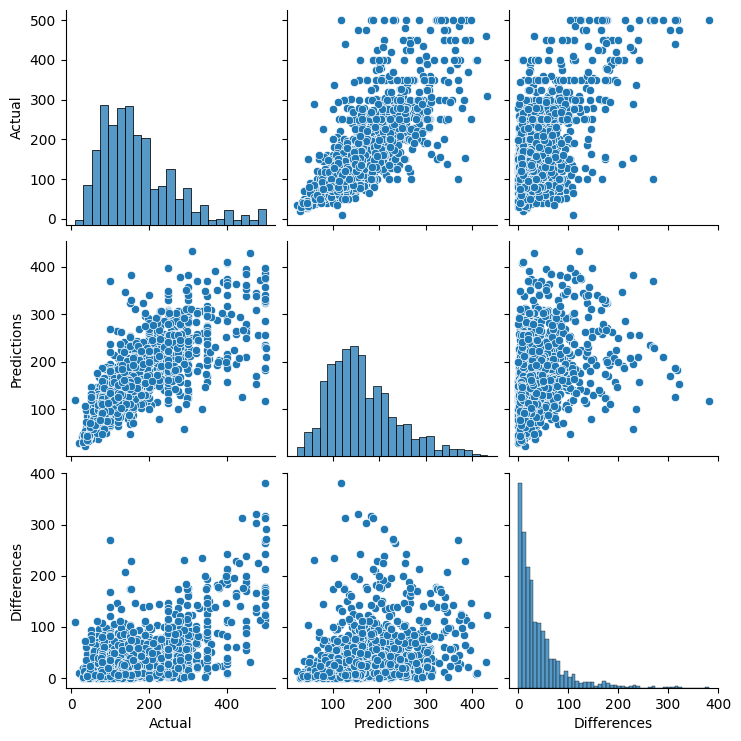

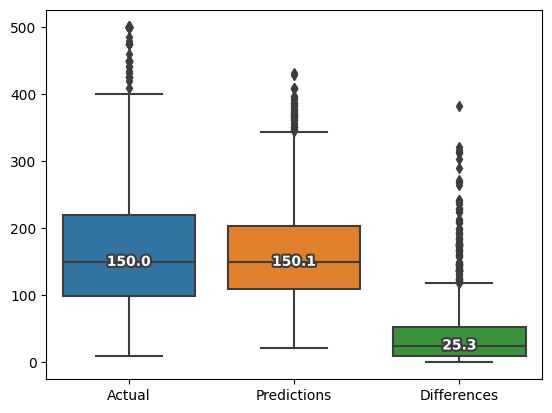

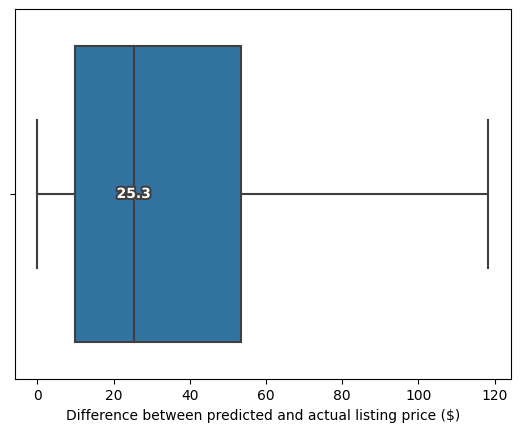

In [350]:
df_pred = pd.DataFrame(y_test)
df_pred['predictions'] = y_pred
df_pred['differences'] = pred_differences
df_pred.columns = ['Actual','Predictions','Differences']

df_pred.head()
print(df_pred.describe())
sns.pairplot(data = df_pred)
plt.show()

def add_median_labels(ax, fmt='.1f'):
    lines = ax.get_lines()
    boxes = [c for c in ax.get_children() if type(c).__name__ == 'PathPatch']
    lines_per_box = int(len(lines) / len(boxes))
    for median in lines[4:len(lines):lines_per_box]:
        x, y = (data.mean() for data in median.get_data())
        # choose value depending on horizontal or vertical plot orientation
        value = x if (median.get_xdata()[1] - median.get_xdata()[0]) == 0 else y
        text = ax.text(x, y, f'{value:{fmt}}', ha='center', va='center',
                       fontweight='bold', color='white')
        # create median-colored border around white text for contrast
        text.set_path_effects([
            path_effects.Stroke(linewidth=3, foreground=median.get_color()),
            path_effects.Normal(),
        ])

ax1 = sns.boxplot(data = df_pred)
add_median_labels(ax1)
plt.show()

ax2 = sns.boxplot(x = 'Differences', data = df_pred, showfliers = False)
add_median_labels(ax2)
plt.xlabel('Difference between predicted and actual listing price ($)')
plt.show()

# Feature Importance

Although the purpose of our application is to provide the most accurate predictions for customer profits, I think it is important to look and communicate to our customers what listing features are the most important in maximizing price so I used the best model to look at feature importance and found that the top 5 most important features were:

- The number of bedrooms
- Location (longitude and latitude)
- The room type(specifically labelling a shared or private room)

Other features did contribute to the model (minimum nights being the strongest predictor remaining) but the listing price was driven primarily by number of bedrooms, location, and level of privacy. 

In [351]:
values = best_model.best_estimator_.named_steps["regressor"].regressor_.feature_importances_

column_names = data.columns[1:len(data.columns)]

df_features = pd.DataFrame({'Label': column_names, 'Importance': values})
df_features = df_features.sort_values(['Importance'],ascending = False)
print(df_features.sort_values(['Importance'],ascending = False))

                        Label  Importance
0                    bedrooms        0.22
3                    latitude        0.18
4                   longitude        0.16
6      room_type_Private room        0.12
2              minimum_nights        0.10
7       room_type_Shared room        0.08
1                   bathrooms        0.06
11        property_type_House        0.02
8   property_type_Condominium        0.02
10        property_type_Hotel        0.01
12        property_type_Other        0.01
9   property_type_Guest Suite        0.01
5        room_type_Hotel room        0.00
